In [18]:
# d6625, d6898
# Generate a model that classifies card suits, from the images created
# Uses images in suits/train and suits/test (but test is not added yet)
# Heavily "inspired" by catsvdogs model from keras. Now heavily modified
# Ripped from value-agent.ipynb

import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

def value_to_label(val):
    suits = ['club', 'diamond', 'heart', 'spade']
    return suits[val]

base_dir = '/Users/James/projects/PycharmProjects/jerry/cards'
train_dir = os.path.join(base_dir, 'suits/train')

datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.2, 2],
    shear_range=3.0,
    zoom_range=[.95, 1.05],
    rotation_range=5,
    validation_split=0.2)

batch_size = 5

train_generator = datagen.flow_from_directory(train_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        subset='training',
                                        shuffle=True)

validation_generator = datagen.flow_from_directory(train_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        subset='validation')

Found 84 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


Sample of input train image
label of clubs (0)
Shape of (5, 150, 150, 3)
Sample of input validation image
label of diamonds (1)
Shape of (5, 150, 150, 3)


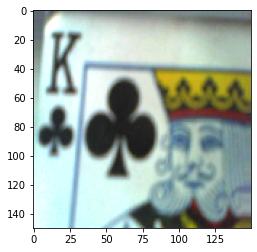

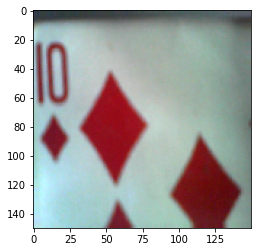

In [2]:
print('Sample of input train image')
for inputs_batch, labels_batch in train_generator:
    plt.imshow(inputs_batch[0].reshape(150,150,3))
    plt.show()
    val = labels_batch[0].argmax(axis=0)
    print('label of', value_to_label(val), '(%a)' % val)
    print('Shape of', inputs_batch.shape)
    break

print('Sample of input validation image')
for inputs_batch, labels_batch in validation_generator:
    plt.imshow(inputs_batch[0].reshape(150,150,3))
    plt.show()
    val = labels_batch[0].argmax(axis=0)
    print('label of', value_to_label(val), '(%a)' % val)
    print('Shape of', inputs_batch.shape)
    break

In [3]:
from keras import layers
from keras import models
from keras.optimizers import RMSprop

# Probably too complex for this situiation, but I don't care
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())  # Dimension reduce
model.add(layers.Dropout(0.5))  # Get rid of conspiracies
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # 4 suits

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [4]:
from keras.callbacks import Callback
class CustomCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 50 == 0:
            print('Epoch', epoch)

from time import time
start = time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1,
    epochs=50,
    callbacks=[CustomCallback()]
)
print('Took',(time()-start).__round__(4),'seconds to train the network')

Epoch 1/50
Epoch 0
16/16 [==============================] - 5s 288ms/step - loss: 1.5516 - acc: 0.2056 - val_loss: 1.2959 - val_acc: 0.4000

In [15]:
save = False
load = False
export = True

if save:
    # save the model
    print('Saving model...')
    model.save('models/suit-v3.h5')

if load:
    # Load it
    print('Loading model...')
    model = models.load_model(os.path.join(base_dir, 'models/suit-v3.h5'))

if export:
    print('Exporting model...')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open('models/suit-v3.tflite', 'wb') as f:
        f.write(tflite_model)


Exporting model...
INFO:tensorflow:Assets written to: /var/folders/1z/jt5b114j573dxlgcpf4d3yyr0000gn/T/tmpovs2zs34/assets


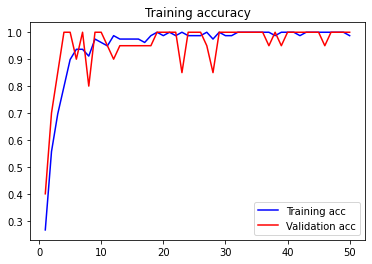

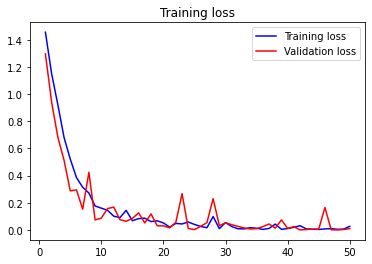

In [8]:
# Visualise the training data
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']


epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
# Test on custom image
from keras.preprocessing import image

print('Testing on all cards')

for suit in os.listdir(train_dir):
    if suit != '.DS_Store':
        dir = os.path.join(train_dir, suit)
        print('Testing on', suit)
        fnames = []
        for fname in os.listdir(dir):
            if fname != '.DS_Store':
                fnames.append(os.path.join(dir, fname))

        correct = 0
        for img_path in fnames[:]:  # only first 3 plz
            img = image.load_img(img_path, target_size=(150,150),
                                 color_mode='rgb')

            x = image.img_to_array(img)
            x = x.astype('float32')/255
            x = x.reshape((1,) + x.shape)  # Convert from (150,150,3) to (1,150,150,3)

            #plt.imshow(img)
            #plt.show()
            pred = np.argmax(model.predict(x, verbose=0)[0])

            if value_to_label(pred) == suit:
                correct += 1

            #print('Pred of', pred.__round__(5), '{' +str(pred.__round__(0)) + '}')
            #print('Meaning the model is ' + str(pred.__round__(2)*100) + '% of it being 1')
        print(correct, '/', fnames.__len__())
    






Testing on all cards
Testing on diamond
26 / 26
Testing on club
26 / 26
Testing on heart
26 / 26
Testing on spade
26 / 26
